<a href="https://colab.research.google.com/github/EnmaSantos/CSE450/blob/main/Copy_of_starter_signs_v2_student_using_advanced_technique_code_chunks_final_with_final_holdout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/holdout.zip
!unzip -q /content/mini_holdout.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm holdout.zip
!rm mini_holdout.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [2]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.


training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)



Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [4]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Crossroad_Ahead', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'Cars_Prohibited(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Bends_Left_Then_Right', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Uncontrolled_Crossroad', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

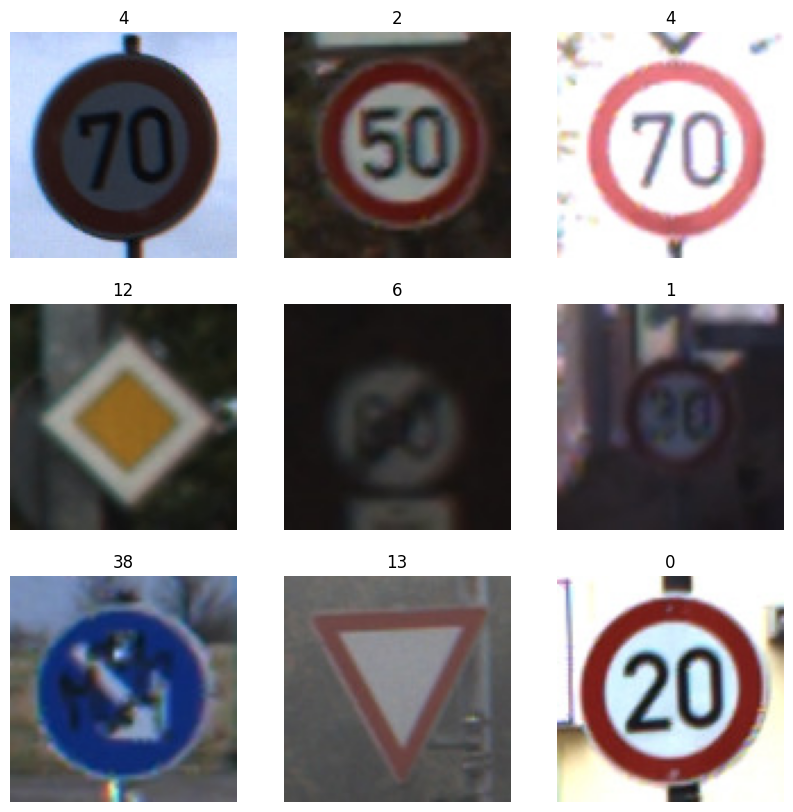

In [5]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)  # Assuming train_generator is a generator
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

plt.show()

In [6]:
# Enhanced data augmentation for traffic sign images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,        # Slight rotations (traffic signs should still be upright)
    width_shift_range=0.1,    # Small horizontal shifts
    height_shift_range=0.1,   # Small vertical shifts
    zoom_range=0.1,           # Slight zooming in/out
    brightness_range=(0.8, 1.2),  # Brightness variations
    shear_range=5,            # Slight shearing
    fill_mode='nearest',
    validation_split=0.2
)

In [7]:
# We still need basic rescaling for validation data, but no augmentation
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [8]:
# Update the generators with the new augmentation settings
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='sparse',
    subset="training",
    seed=42
)

validation_generator = validation_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='sparse',
    subset="validation",
    seed=42
)


Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


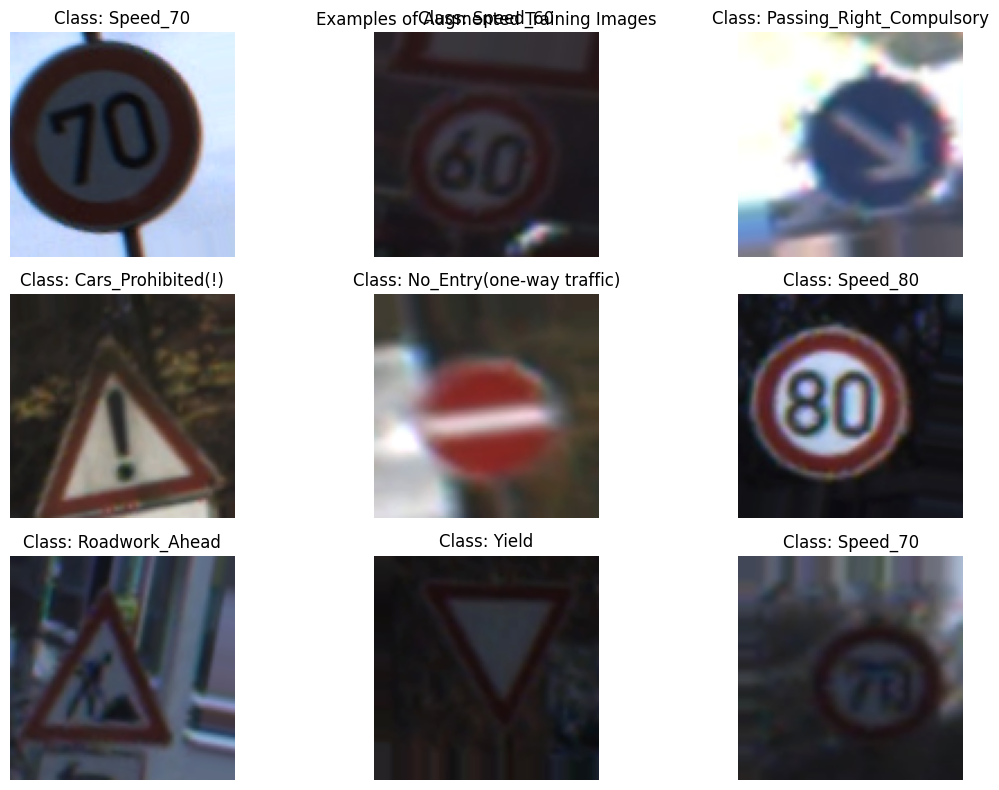

In [9]:
# Visualize some augmented images to verify the augmentation
plt.figure(figsize=(12, 8))
for i in range(9):
    augmented_images, labels = next(train_generator)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0])
    plt.title(f"Class: {target_names[int(labels[0])]}")
    plt.axis("off")
plt.tight_layout()
plt.suptitle("Examples of Augmented Training Images")
plt.show()

In [10]:
# More libraries to further improve the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [11]:
# Define a more advanced CNN architecture
improved_model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(100, 100, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Second convolutional block
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Third convolutional block
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Flatten and dense layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(43, activation='softmax')  # 43 classes for German traffic signs
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Compile the model with a lower learning rate
improved_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
# Print model summary
improved_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 50, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,750,603 (37.20 MB)

 Trainable params: 9,748,683 (37.19 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [14]:
# Define callbacks to improve training
callbacks = [
    # Reduce learning rate when validation accuracy plateaus
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),

    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # Save the best model
    ModelCheckpoint(
        'best_traffic_sign_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [15]:
# Train the model with callbacks
history = improved_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  # We'll use early stopping to determine actual epochs
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.3576 - loss: 2.5076
Epoch 1: val_accuracy improved from -inf to 0.64686, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 150s 137ms/step - accuracy: 0.3578 - loss: 2.5068 - val_accuracy: 0.6469 - val_loss: 1.4161 - learning_rate: 0.0010
Epoch 2/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8012 - loss: 0.6292
Epoch 2: val_accuracy improved from 0.64686 to 0.85410, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 181s 127ms/step - accuracy: 0.8012 - loss: 0.6291 - val_accuracy: 0.8541 - val_loss: 0.5259 - learning_rate: 0.0010
Epoch 3/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9053 - loss: 0.2998
Epoch 3: val_accuracy improved from 0.85410 to 0.94771, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 143s 128ms/step - accuracy: 0.9053 - loss: 0.2997 - val_accuracy: 0.9477 - val_loss: 0.1874 - learning_rate: 0.0010
Epoch 4/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9583 - loss: 0.1381
Epoch 4: val_accuracy did not improve from 0.94771
981/981 ━━━━━━━━━━━━━━━━━━━━ 122s 124ms/step - accuracy: 0.9583 - loss: 0.1381 - val_accuracy: 0.9387 - val_loss: 0.3485 - learning_rate: 0.0010
Epoch 5/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9714 - loss: 0.0898
Epoch 5: val_accuracy did not improve from 0.94771
981/981 ━━━━━━━━━━━━━━━━━━━━ 124s 127ms/step - accuracy: 0.9714 - loss: 0.0898 - val_accuracy: 0.9290 - val_loss: 0.2572 - learning_rate: 0.0010
Epoch 6/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9726 - loss: 0.0883
Epoch 6: val_accuracy improved from 0.94771 to 0.95766, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 125s 128ms/step - accuracy: 0.9726 - loss: 0.0883 - val_accuracy: 0.9577 - val_loss: 0.1299 - learning_rate: 0.0010
Epoch 7/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9782 - loss: 0.0653
Epoch 7: val_accuracy did not improve from 0.95766
981/981 ━━━━━━━━━━━━━━━━━━━━ 126s 128ms/step - accuracy: 0.9782 - loss: 0.0653 - val_accuracy: 0.9412 - val_loss: 0.2262 - learning_rate: 0.0010
Epoch 8/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9574 - loss: 0.1450
Epoch 8: val_accuracy improved from 0.95766 to 0.96748, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 125s 127ms/step - accuracy: 0.9574 - loss: 0.1449 - val_accuracy: 0.9675 - val_loss: 0.1052 - learning_rate: 0.0010
Epoch 9/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9793 - loss: 0.0684
Epoch 9: val_accuracy improved from 0.96748 to 0.96952, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 142s 127ms/step - accuracy: 0.9793 - loss: 0.0684 - val_accuracy: 0.9695 - val_loss: 0.1345 - learning_rate: 0.0010
Epoch 10/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9871 - loss: 0.0434
Epoch 10: val_accuracy did not improve from 0.96952
981/981 ━━━━━━━━━━━━━━━━━━━━ 124s 126ms/step - accuracy: 0.9871 - loss: 0.0434 - val_accuracy: 0.9510 - val_loss: 0.1671 - learning_rate: 0.0010
Epoch 11/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9852 - loss: 0.0505
Epoch 11: val_accuracy did not improve from 0.96952
981/981 ━━━━━━━━━━━━━━━━━━━━ 124s 126ms/step - accuracy: 0.9852 - loss: 0.0505 - val_accuracy: 0.9566 - val_loss: 0.1921 - learning_rate: 0.0010
Epoch 12/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9843 - loss: 0.0481
Epoch 12: val_accuracy improved from 0.96952 to 0.97092, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 122s 124ms/step - accuracy: 0.9843 - loss: 0.0481 - val_accuracy: 0.9709 - val_loss: 0.1058 - learning_rate: 0.0010
Epoch 13/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9875 - loss: 0.0386
Epoch 13: val_accuracy improved from 0.97092 to 0.97169, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 145s 128ms/step - accuracy: 0.9875 - loss: 0.0386 - val_accuracy: 0.9717 - val_loss: 0.1066 - learning_rate: 0.0010
Epoch 14/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9875 - loss: 0.0405
Epoch 14: val_accuracy improved from 0.97169 to 0.97424, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 121s 124ms/step - accuracy: 0.9875 - loss: 0.0405 - val_accuracy: 0.9742 - val_loss: 0.1287 - learning_rate: 0.0010
Epoch 15/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9892 - loss: 0.0344
Epoch 15: val_accuracy did not improve from 0.97424
981/981 ━━━━━━━━━━━━━━━━━━━━ 122s 124ms/step - accuracy: 0.9892 - loss: 0.0344 - val_accuracy: 0.9661 - val_loss: 0.1326 - learning_rate: 0.0010
Epoch 16/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9895 - loss: 0.0344
Epoch 16: val_accuracy did not improve from 0.97424
981/981 ━━━━━━━━━━━━━━━━━━━━ 121s 123ms/step - accuracy: 0.9895 - loss: 0.0344 - val_accuracy: 0.9688 - val_loss: 0.1493 - learning_rate: 0.0010
Epoch 17/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9900 - loss: 0.0347
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: val_accuracy did not improve from 0.97424
981/981 ━━━━━━━━━━━━━━━━━━━━ 121s 123ms/step - accuracy: 0.9900 

981/981 ━━━━━━━━━━━━━━━━━━━━ 146s 127ms/step - accuracy: 0.9935 - loss: 0.0219 - val_accuracy: 0.9841 - val_loss: 0.0622 - learning_rate: 5.0000e-04
Epoch 19/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9962 - loss: 0.0121
Epoch 19: val_accuracy did not improve from 0.98406
981/981 ━━━━━━━━━━━━━━━━━━━━ 123s 125ms/step - accuracy: 0.9962 - loss: 0.0121 - val_accuracy: 0.9733 - val_loss: 0.1271 - learning_rate: 5.0000e-04
Epoch 20/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9953 - loss: 0.0151
Epoch 20: val_accuracy did not improve from 0.98406
981/981 ━━━━━━━━━━━━━━━━━━━━ 120s 122ms/step - accuracy: 0.9953 - loss: 0.0151 - val_accuracy: 0.9754 - val_loss: 0.1049 - learning_rate: 5.0000e-04
Epoch 21/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9965 - loss: 0.0103
Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 21: val_accuracy did not improve from 0.98406
981/981 ━━━━━━━━━━━━━━━━━━━━ 122s 124ms/step - accur

981/981 ━━━━━━━━━━━━━━━━━━━━ 123s 126ms/step - accuracy: 0.9974 - loss: 0.0086 - val_accuracy: 0.9844 - val_loss: 0.0600 - learning_rate: 2.5000e-04
Epoch 23/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9979 - loss: 0.0069
Epoch 23: val_accuracy did not improve from 0.98444
981/981 ━━━━━━━━━━━━━━━━━━━━ 122s 124ms/step - accuracy: 0.9979 - loss: 0.0069 - val_accuracy: 0.9824 - val_loss: 0.0727 - learning_rate: 2.5000e-04
Epoch 24/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9973 - loss: 0.0074
Epoch 24: val_accuracy improved from 0.98444 to 0.98635, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 123s 125ms/step - accuracy: 0.9973 - loss: 0.0074 - val_accuracy: 0.9864 - val_loss: 0.0537 - learning_rate: 2.5000e-04
Epoch 25/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9980 - loss: 0.0054
Epoch 25: val_accuracy improved from 0.98635 to 0.98878, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 119s 121ms/step - accuracy: 0.9980 - loss: 0.0054 - val_accuracy: 0.9888 - val_loss: 0.0409 - learning_rate: 2.5000e-04
Epoch 26/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9980 - loss: 0.0058
Epoch 26: val_accuracy did not improve from 0.98878
981/981 ━━━━━━━━━━━━━━━━━━━━ 120s 122ms/step - accuracy: 0.9980 - loss: 0.0058 - val_accuracy: 0.9879 - val_loss: 0.0464 - learning_rate: 2.5000e-04
Epoch 27/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9974 - loss: 0.0068
Epoch 27: val_accuracy did not improve from 0.98878
981/981 ━━━━━━━━━━━━━━━━━━━━ 122s 125ms/step - accuracy: 0.9974 - loss: 0.0068 - val_accuracy: 0.9841 - val_loss: 0.0606 - learning_rate: 2.5000e-04
Epoch 28/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9983 - loss: 0.0054
Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 28: val_accuracy did not improve from 0.98878
981/981 ━━━━━━━━━━━━━━━━━━━━ 125s 127ms/step - accur

981/981 ━━━━━━━━━━━━━━━━━━━━ 123s 126ms/step - accuracy: 0.9985 - loss: 0.0054 - val_accuracy: 0.9906 - val_loss: 0.0293 - learning_rate: 1.2500e-04
Epoch 30/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9985 - loss: 0.0047
Epoch 30: val_accuracy did not improve from 0.99056
981/981 ━━━━━━━━━━━━━━━━━━━━ 122s 125ms/step - accuracy: 0.9985 - loss: 0.0047 - val_accuracy: 0.9899 - val_loss: 0.0340 - learning_rate: 1.2500e-04
Epoch 31/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9990 - loss: 0.0039
Epoch 31: val_accuracy did not improve from 0.99056
981/981 ━━━━━━━━━━━━━━━━━━━━ 122s 125ms/step - accuracy: 0.9990 - loss: 0.0039 - val_accuracy: 0.9830 - val_loss: 0.0556 - learning_rate: 1.2500e-04
Epoch 32/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9987 - loss: 0.0032
Epoch 32: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 32: val_accuracy did not improve from 0.99056
981/981 ━━━━━━━━━━━━━━━━━━━━ 120s 122ms/step - accura

In [16]:
# Plot training history
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

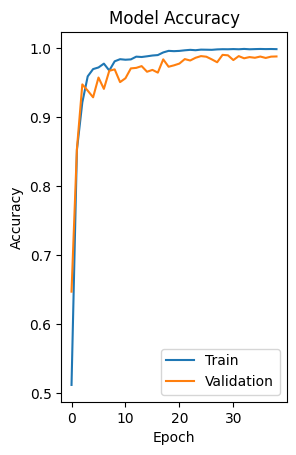

In [17]:
# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

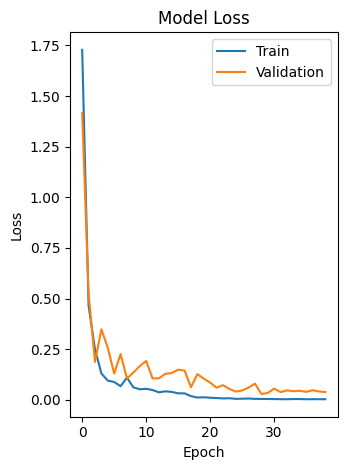

In [18]:
# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [19]:
# This is an optional advanced addition to help understand what the model is learning
from tensorflow.keras.models import Model
import cv2
import numpy as np

# Function to create a heatmap of what the CNN is focusing on
def generate_cam(model, img_array, class_idx, layer_name='conv2d_5'):
    # Create a model that will output the last conv layer
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Convert image to array and perform the same preprocessing
    img_array = np.expand_dims(img_array, axis=0)

    # Compute gradient of the predicted class with respect to feature map activations
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_channel = predictions[:, class_idx]

    # Gradient of the class output with respect to the output feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Vector of mean gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight feature maps by gradient importance
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    # Resize heatmap to original image size
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert to RGB for overlay
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap on original image
    superimposed_img = heatmap * 0.4 + img_array[0] * 255
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return superimposed_img

In [20]:
# Additional imports for evaluation metrics
import os
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [21]:
# Step 1: Load the mini holdout dataset
mini_holdout_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
mini_holdout_generator = test_datagen.flow_from_directory(
        mini_holdout_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode=None,
        shuffle=False,
        batch_size=1)

Found 201 images belonging to 1 classes.


In [22]:
# Step 2: Get the filenames from the generator
filenames = mini_holdout_generator.filenames
base_filenames = [os.path.basename(filename) for filename in filenames]
print(f"Number of images in mini_holdout: {len(base_filenames)}")

Number of images in mini_holdout: 201


In [23]:
# Step 3: Load ground truth labels from the CSV file
ground_truth_df = pd.read_csv('/content/mini_holdout_answers.csv')
print("First few rows of the ground truth data:")
print(ground_truth_df.head())
print(f"Number of entries in CSV: {len(ground_truth_df)}")

First few rows of the ground truth data:
    Filename  ClassId
0  00000.jpg       16
1  00001.jpg        1
2  00002.jpg       38
3  00003.jpg       33
4  00004.jpg       11
Number of entries in CSV: 201


In [24]:
# Step 4: Generate predictions with our trained model
# FIXED: Changed 'model' to 'improved_model'
mini_holdout_generator.reset()
mini_holdout_probabilities = improved_model.predict(mini_holdout_generator)
mini_holdout_predictions = [np.argmax(probas) for probas in mini_holdout_probabilities]

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [25]:
# Step 5: Create a DataFrame with predictions and filenames
predictions_df = pd.DataFrame({
    'Filename': base_filenames,
    'Predicted_ClassId': mini_holdout_predictions
})

In [26]:
# Step 6: Merge with ground truth to ensure proper alignment
evaluation_df = pd.merge(ground_truth_df, predictions_df, on='Filename', how='inner')
print(f"Number of matched predictions: {len(evaluation_df)}")

Number of matched predictions: 201


In [27]:
# Step 7: Calculate accuracy
accuracy = accuracy_score(evaluation_df['ClassId'], evaluation_df['Predicted_ClassId'])
print(f"\nModel Accuracy on Mini Holdout Set: {accuracy:.4f} ({accuracy*100:.2f}%)")


Model Accuracy on Mini Holdout Set: 1.0000 (100.00%)


In [28]:
# Step 8: Find the unique classes in the ground truth data
unique_classes = sorted(evaluation_df['ClassId'].unique())
print(f"\nNumber of unique classes in mini holdout: {len(unique_classes)}")
print(f"Classes present: {unique_classes}")


Number of unique classes in mini holdout: 38
Classes present: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 40, 41]


In [29]:
# Create a mapping from class ID to index position for the classification report
present_target_names = [target_names[i] for i in unique_classes]

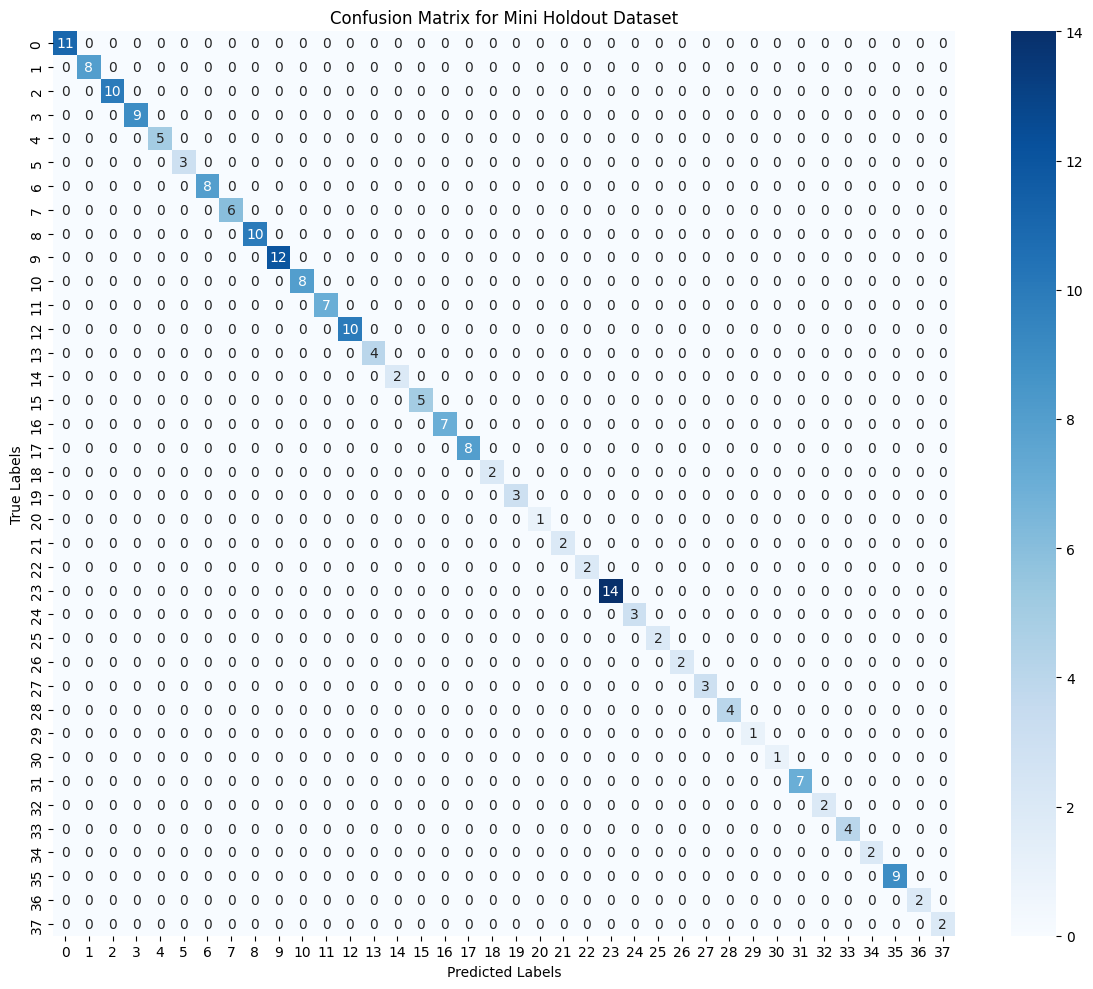

In [30]:
# Step 10: Create and visualize confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(
    evaluation_df['ClassId'],
    evaluation_df['Predicted_ClassId'],
    labels=unique_classes  # Use only the classes that are present
)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Mini Holdout Dataset')
plt.tight_layout()
plt.show()


In [31]:
# Step 11: Visualize examples of correct and incorrect predictions
plt.figure(figsize=(20, 16))
count_correct = 0
count_incorrect = 0
examples_to_show = 5

<Figure size 2000x1600 with 0 Axes>

In [32]:
# Create image mapping for easier lookup
mini_holdout_generator.reset()
image_dict = {}
for i, image in enumerate(mini_holdout_generator):
    if i >= len(base_filenames):
        break
    image_dict[base_filenames[i]] = image[0]

Number of unique classes in evaluation dataset: 38
Number of correctly classified unique classes: 38
Number of misclassifications: 0


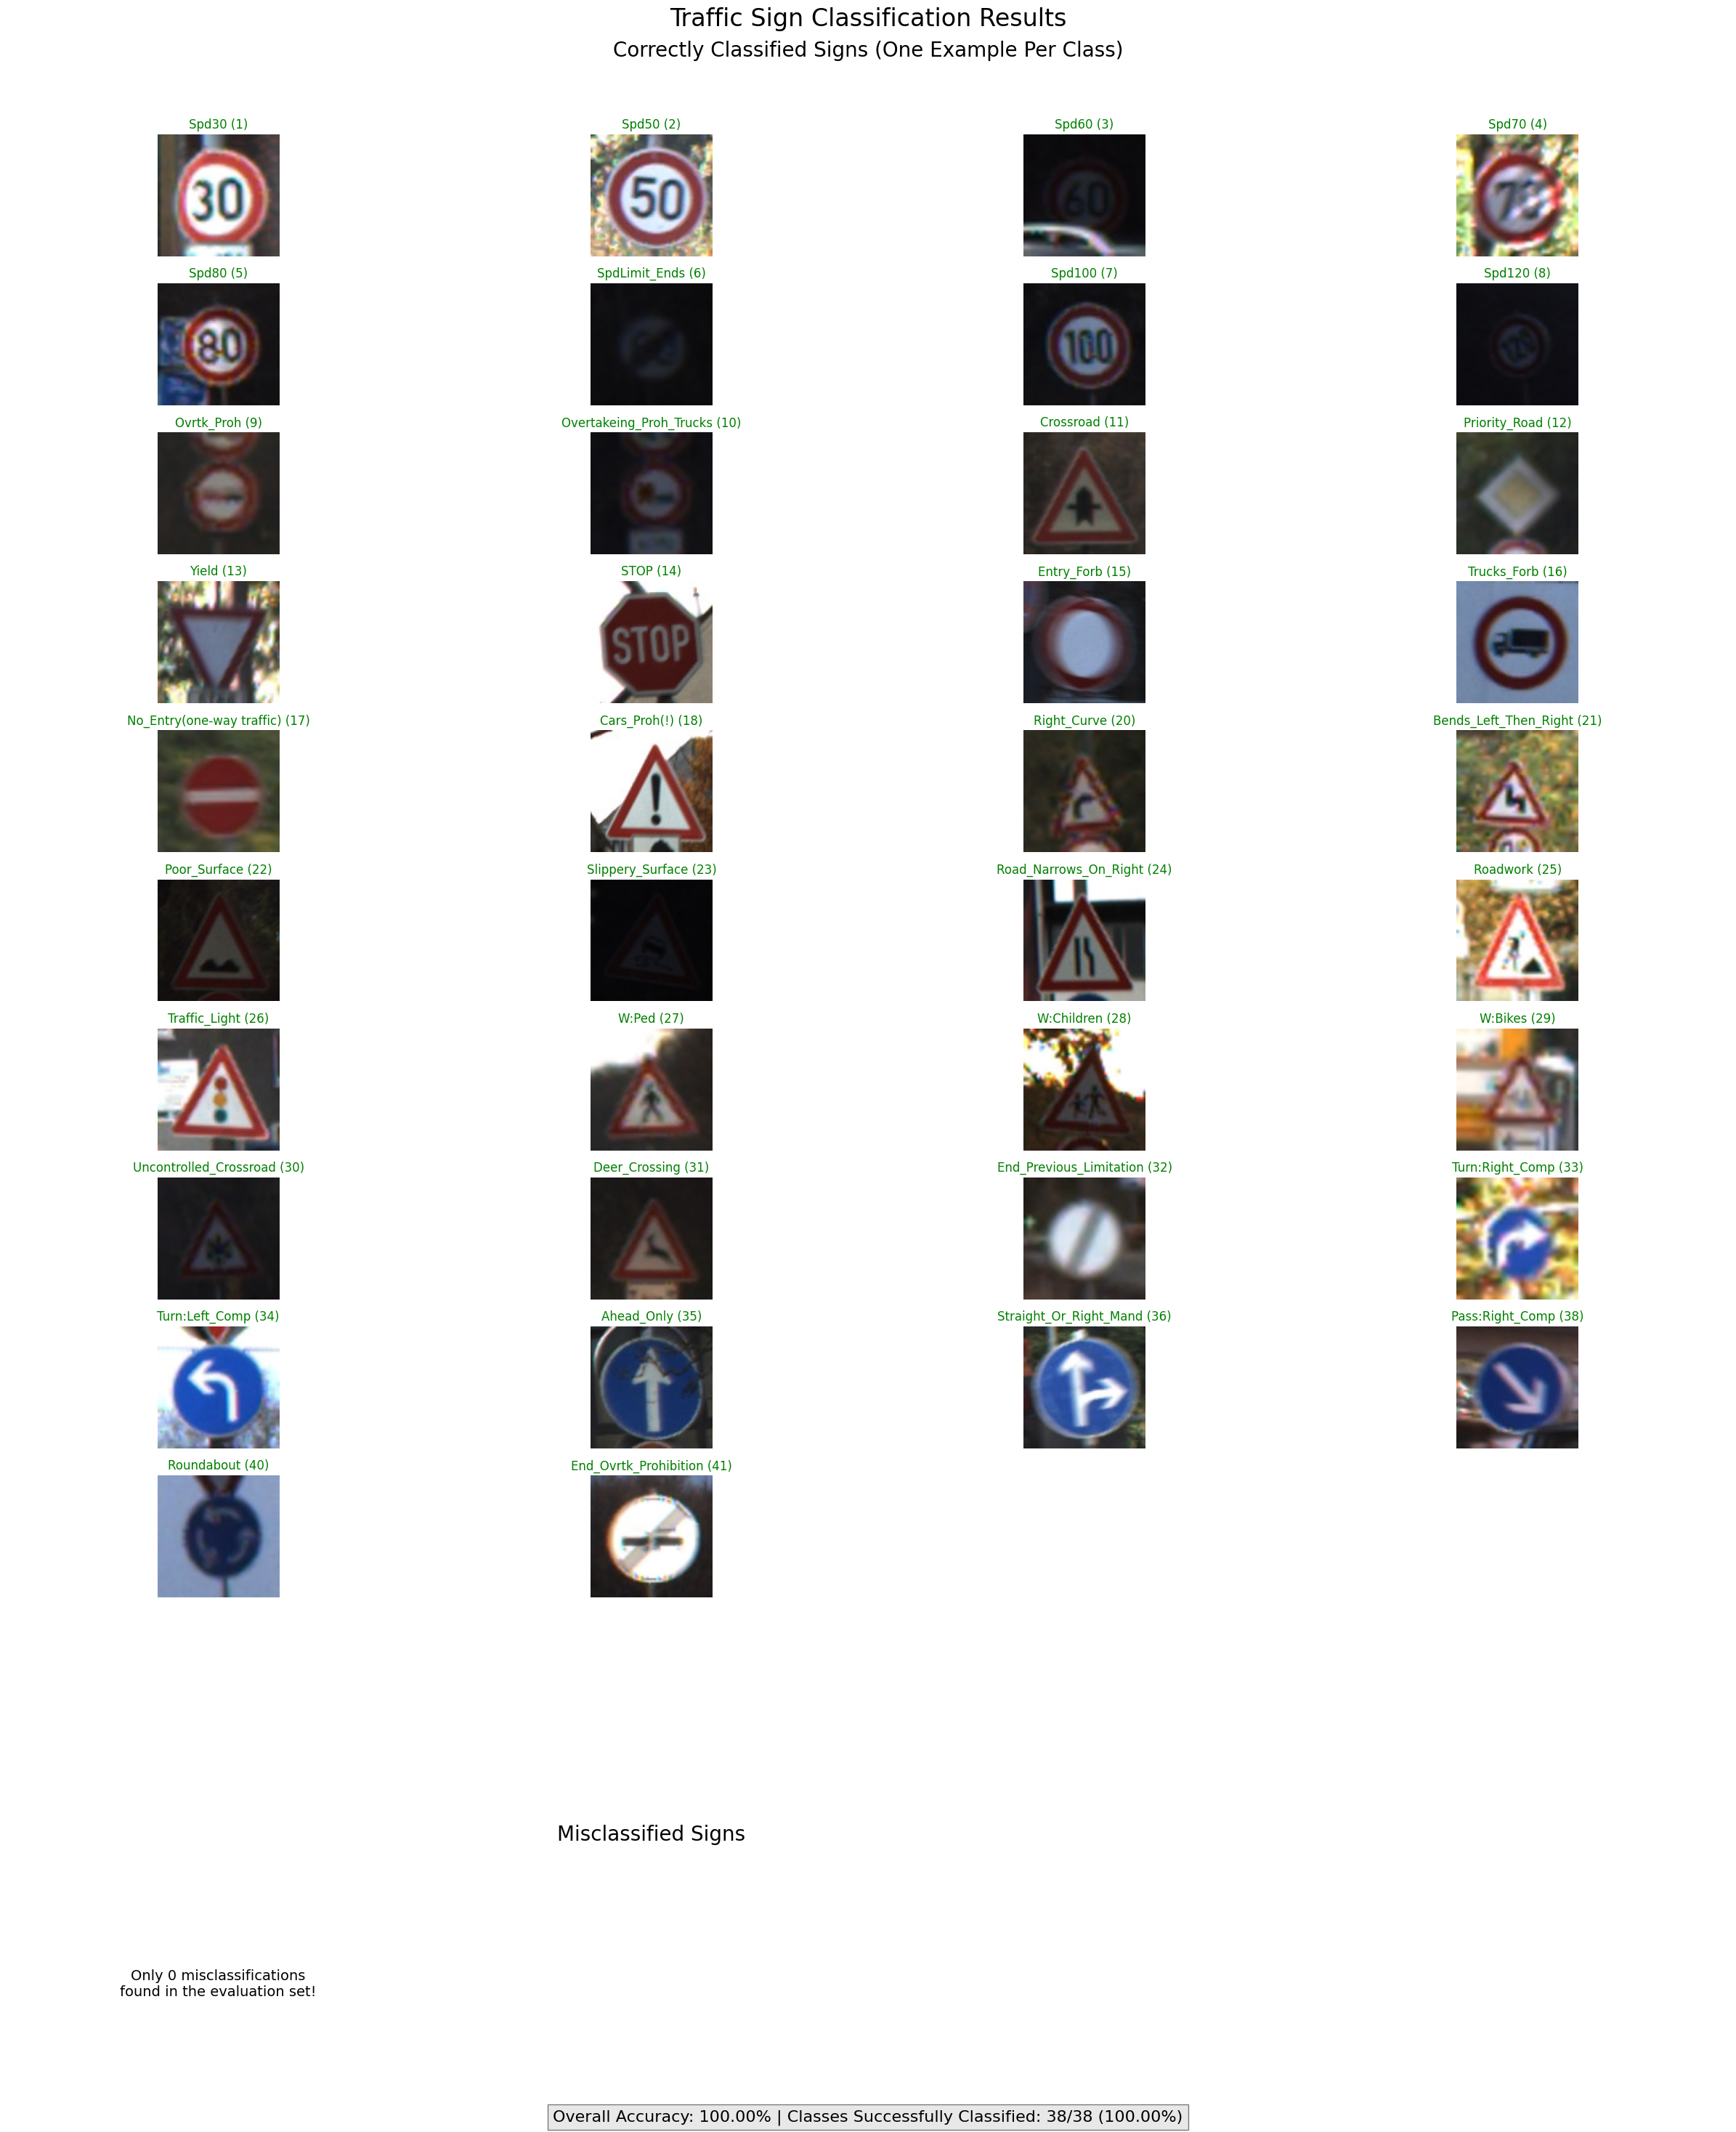

In [33]:
# Comprehensive visualization with LARGER images of each class
plt.figure(figsize=(24, 30))  # Taller figure to accommodate larger images

# Function to create shorter sign names
def shorten_sign_name(name):
    name = name.replace('Warning_', 'W:')
    name = name.replace('Speed_', 'Spd')
    name = name.replace('Compulsory', 'Comp')
    name = name.replace('Roadwork_Ahead', 'Roadwork')
    name = name.replace('Crossroad_Ahead', 'Crossroad')
    name = name.replace('Pedestrians', 'Ped')
    name = name.replace('Turning_', 'Turn:')
    name = name.replace('_Ahead', '')
    name = name.replace('Prohibited', 'Proh')
    name = name.replace('Forbidden', 'Forb')
    name = name.replace('Overtaking', 'Ovrtk')
    name = name.replace('Mandatory', 'Mand')
    name = name.replace('Passing_', 'Pass:')
    return name

# Top section title
plt.suptitle("Traffic Sign Classification Results", fontsize=24, y=0.98)

# Get all unique classes in the evaluation dataset
unique_classes = sorted(evaluation_df['ClassId'].unique())
print(f"Number of unique classes in evaluation dataset: {len(unique_classes)}")

# Create dictionaries to store one example per correctly classified class and all misclassifications
class_examples = {}  # Will hold one example per class: {class_id: (image, class_id)}
incorrect_examples = []  # Will hold all misclassifications

# First pass: collect one example of each correctly classified class and all misclassifications
for _, row in evaluation_df.iterrows():
    is_correct = row['ClassId'] == row['Predicted_ClassId']
    class_id = row['ClassId']

    image = image_dict.get(row['Filename'])
    if image is None:
        continue

    if is_correct:
        # Only store this example if we don't already have one for this class
        if class_id not in class_examples:
            class_examples[class_id] = (image, class_id)
    else:
        # Store all misclassifications
        incorrect_examples.append((image, row['ClassId'], row['Predicted_ClassId']))

# Calculate layout parameters
num_correct_classes = len(class_examples)
print(f"Number of correctly classified unique classes: {num_correct_classes}")
num_incorrect = len(incorrect_examples)
print(f"Number of misclassifications: {num_incorrect}")

# Create explicit section titles
fig = plt.gcf()
fig.text(0.5, 0.96, "Correctly Classified Signs (One Example Per Class)",
         fontsize=20, ha='center', va='center')

# Use fewer columns to make images bigger
correct_cols = 4  # Reduced from 5 to 4
correct_rows = (num_correct_classes + correct_cols - 1) // correct_cols  # Ceiling division

# Create section for correctly classified examples
# Calculate how many subplots we'll need in total
total_subplots = correct_rows * correct_cols

# Display one example per correctly classified class
for i, (class_id, (image, _)) in enumerate(sorted(class_examples.items())):
    if i < total_subplots:  # Make sure we don't go outside our grid
        row = i // correct_cols
        col = i % correct_cols
        position = row * correct_cols + col + 1

        ax = plt.subplot(correct_rows + 3, correct_cols, position)  # +3 rows for misclassifications and buffer
        plt.imshow((image * 255).astype("uint8"))

        # Get the sign name and shorten it
        sign_name = shorten_sign_name(target_names[class_id])
        plt.title(f"{sign_name} ({class_id})", color='green', fontsize=12)  # Larger font
        plt.axis('off')

# Add a divider section with more space
buffer_row = correct_rows + 1
for col in range(correct_cols):
    ax = plt.subplot(correct_rows + 3, correct_cols, buffer_row * correct_cols + col + 1)
    plt.axis('off')
    if col == 1:  # Position adjusted for 4 columns
        plt.text(0.5, 0.5, "Misclassified Signs",
                 fontsize=20, ha='center', va='center', transform=ax.transAxes)

# Display misclassified examples in the last row with larger images
for i, (image, true_id, pred_id) in enumerate(incorrect_examples):
    if i < correct_cols:  # Only show up to 4 misclassifications (to match columns)
        position = (buffer_row + 1) * correct_cols + i + 1
        ax = plt.subplot(correct_rows + 3, correct_cols, position)
        plt.imshow((image * 255).astype("uint8"))

        # Place labels below the image
        true_name = shorten_sign_name(target_names[true_id])
        pred_name = shorten_sign_name(target_names[pred_id])

        plt.text(0.5, -0.10, f"True: {true_name} ({true_id})",
                color='black', fontsize=11, ha='center', transform=ax.transAxes)
        plt.text(0.5, -0.20, f"Pred: {pred_name} ({pred_id})",
                color='red', fontsize=11, ha='center', transform=ax.transAxes)
        plt.axis('off')

# If we have fewer than 4 incorrect examples, add a note
if num_incorrect < correct_cols:
    position = (buffer_row + 1) * correct_cols + num_incorrect + 1
    ax = plt.subplot(correct_rows + 3, correct_cols, position)
    plt.text(0.5, 0.5, f"Only {num_incorrect} misclassifications\nfound in the evaluation set!",
            horizontalalignment='center', verticalalignment='center', fontsize=14)  # Larger font
    plt.axis('off')

# Add performance metrics as text at the bottom
overall_accuracy = len(evaluation_df[evaluation_df['ClassId'] == evaluation_df['Predicted_ClassId']]) / len(evaluation_df)
class_coverage = len(class_examples) / len(unique_classes) if unique_classes else 0

metrics_text = (
    f"Overall Accuracy: {overall_accuracy:.2%} | "
    f"Classes Successfully Classified: {len(class_examples)}/{len(unique_classes)} ({class_coverage:.2%})"
)

plt.figtext(0.5, 0.01, metrics_text,
            ha="center", fontsize=16, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})  # Larger font

# Adjust spacing for clarity and to reduce crowding
plt.subplots_adjust(hspace=0.8, wspace=0.4)  # More space between plots
plt.tight_layout(rect=[0, 0.04, 1, 0.95])
plt.show()

In [34]:

plt.suptitle("Examples of Correct (top) and Incorrect (bottom) Predictions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

<Figure size 640x480 with 0 Axes>

In [35]:
# Step 12: Analyze which sign types have the highest error rates
evaluation_df['is_correct'] = evaluation_df['ClassId'] == evaluation_df['Predicted_ClassId']
error_df = evaluation_df[~evaluation_df['is_correct']]

In [36]:
if len(error_df) > 0:
    # Map class IDs to their names
    error_df['true_sign_name'] = error_df['ClassId'].map(lambda x: target_names[x])

    # Count errors by sign type
    error_counts = error_df['true_sign_name'].value_counts()

    print("\nSign types with the highest error counts:")
    print(error_counts.head(10))

    # Create a bar chart of the most frequently misclassified signs
    plt.figure(figsize=(12, 6))
    error_counts.head(min(10, len(error_counts))).plot(kind='bar')
    plt.title('Sign Types with Highest Error Counts')
    plt.xlabel('Sign Type')
    plt.ylabel('Error Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [37]:
# Make sure there's no indentation at the beginning of this line
if len(error_df) > 5:  # Only if we have enough errors to analyze
    error_df['pred_sign_name'] = error_df['Predicted_ClassId'].map(lambda x: target_names[x])
    confusion_pairs = error_df.groupby(['true_sign_name', 'pred_sign_name']).size()
    confusion_pairs = confusion_pairs.sort_values(ascending=False)

    print("\nMost common confusion patterns:")
    print(confusion_pairs.head(min(10, len(confusion_pairs))))
    print("\nThese patterns indicate which signs are most frequently confused with each other.")

In [38]:
# This code should be added after running the model and generating predictions

# Create a detailed visualization of incorrectly classified images
def visualize_errors(evaluation_df, image_dict, target_names, max_examples=20):
    """
    Creates a detailed visualization of incorrectly classified images

    Parameters:
    evaluation_df - DataFrame with true and predicted classes
    image_dict - Dictionary mapping filenames to image data
    target_names - List of class names
    max_examples - Maximum number of examples to display
    """
    # Filter for incorrect predictions only
    error_df = evaluation_df[evaluation_df['ClassId'] != evaluation_df['Predicted_ClassId']].copy()

    # Get the number of errors to display (up to max_examples)
    num_errors = min(len(error_df), max_examples)

    if num_errors == 0:
        print("No errors found! The model correctly classified all images.")
        return

    # Calculate grid dimensions
    cols = 4  # 4 images per row
    rows = (num_errors + cols - 1) // cols  # Ceiling division

    # Create a larger figure to accommodate more images
    plt.figure(figsize=(20, 5 * rows))

    # Add each incorrect prediction to the plot
    for i, (_, row) in enumerate(error_df.head(num_errors).iterrows()):
        if i >= max_examples:
            break

        # Get the image
        image = image_dict.get(row['Filename'])
        if image is None:
            continue

        # Create subplot
        plt.subplot(rows, cols, i + 1)
        plt.imshow((image * 255).astype("uint8"))

        # Get true and predicted class names
        true_name = target_names[row['ClassId']]
        pred_name = target_names[row['Predicted_ClassId']]

        # Display detailed information
        plt.title(f"True: {true_name}\nPred: {pred_name}", color='red')
        plt.xlabel(f"Filename: {row['Filename']}")
        plt.axis('off')

    plt.suptitle(f"Incorrectly Classified Images (showing {num_errors} out of {len(error_df)} errors)",
                fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Additionally, group errors by true class for analysis
    print("\nErrors grouped by true sign type:")
    error_class_counts = error_df.groupby('ClassId').size()
    for class_id, count in error_class_counts.items():
        print(f"{target_names[class_id]}: {count} errors")

    # Show confusion patterns (what signs get confused with what)
    print("\nDetailed confusion patterns:")
    error_df['true_sign_name'] = [target_names[x] for x in error_df['ClassId']]
    error_df['pred_sign_name'] = [target_names[x] for x in error_df['Predicted_ClassId']]

    confusion_patterns = error_df.groupby(['true_sign_name', 'pred_sign_name']).size()
    for (true_name, pred_name), count in confusion_patterns.items():
        print(f"{true_name} mistaken as {pred_name}: {count} times")

# Call this function to visualize errors
visualize_errors(evaluation_df, image_dict, target_names, max_examples=20)

No errors found! The model correctly classified all images.


In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Ensure image_size matches what you used for training
image_size = (100, 100)

# Set up the test data generator
test_dir = '/content/'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode=None,  # Set to None to only get images without labels
        batch_size=32,
        shuffle=False)

# Make predictions using your improved_model
probabilities = improved_model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]

# Get the filenames to create the submission file
filenames = [f.split('/')[-1] for f in test_generator.filenames]

# Create a pandas DataFrame for submission
import pandas as pd
submission_df = pd.DataFrame({
    'Filename': filenames,
    'ClassId': predictions
})

# Save to CSV
submission_df.to_csv('holdout_predictions.csv', index=False)
print("Predictions saved to 'holdout_predictions.csv'")

Found 12630 images belonging to 1 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


395/395 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step
Predictions saved to 'holdout_predictions.csv'


In [40]:
import random

# Get random sample of filenames and their predictions
sample_size = 50
sample_indices = random.sample(range(len(filenames)), sample_size)

for idx in sample_indices:
    print(f"File: {filenames[idx]}, Predicted Class: {predictions[idx]}")

File: 05231.jpg, Predicted Class: 3
File: 09158.jpg, Predicted Class: 27
File: 11612.jpg, Predicted Class: 17
File: 04700.jpg, Predicted Class: 33
File: 04593.jpg, Predicted Class: 10
File: 08252.jpg, Predicted Class: 9
File: 09865.jpg, Predicted Class: 4
File: 04048.jpg, Predicted Class: 27
File: 03184.jpg, Predicted Class: 3
File: 03195.jpg, Predicted Class: 11
File: 04419.jpg, Predicted Class: 8
File: 03711.jpg, Predicted Class: 2
File: 11977.jpg, Predicted Class: 25
File: 02823.jpg, Predicted Class: 12
File: 12379.jpg, Predicted Class: 12
File: 12218.jpg, Predicted Class: 39
File: 03605.jpg, Predicted Class: 37
File: 10234.jpg, Predicted Class: 12
File: 07895.jpg, Predicted Class: 35
File: 11963.jpg, Predicted Class: 25
File: 01130.jpg, Predicted Class: 13
File: 12357.jpg, Predicted Class: 13
File: 00734.jpg, Predicted Class: 15
File: 07223.jpg, Predicted Class: 2
File: 03641.jpg, Predicted Class: 10
File: 09571.jpg, Predicted Class: 35
File: 12488.jpg, Predicted Class: 38
File: 04